In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import plotly.express as px

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:


path_to_genre = os.path.join(os.path.sep,'content','gdrive','My Drive','Colab Notebooks','LSMA', 'Practice_3_Recommenders-part1','goodbooks-10k-master')


path_ratings = '/content/gdrive/My Drive/Colab Notebooks/LSMA/Practice_3_Recommenders-part1/goodbooks-10k-master/ratings.csv'
path_toread = '/content/gdrive/My Drive/Colab Notebooks/LSMA/Practice_3_Recommenders-part1/goodbooks-10k-master/to_read.csv'
path_book = '/content/gdrive/My Drive/Colab Notebooks/LSMA/Practice_3_Recommenders-part1/goodbooks-10k-master/books.csv'
path_tags = '/content/gdrive/My Drive/Colab Notebooks/LSMA/Practice_3_Recommenders-part1/goodbooks-10k-master/tags.csv'
path_booktags = '/content/gdrive/My Drive/Colab Notebooks/LSMA/Practice_3_Recommenders-part1/goodbooks-10k-master/book_tags.csv'


df_ratings = pd.read_csv( '/content/gdrive/My Drive/Colab Notebooks/LSMA/Practice_3_Recommenders-part1/goodbooks-10k-master/ratings.csv' )
df_toread = pd.read_csv( '/content/gdrive/My Drive/Colab Notebooks/LSMA/Practice_3_Recommenders-part1/goodbooks-10k-master/to_read.csv' )
df_book = pd.read_csv( '/content/gdrive/My Drive/Colab Notebooks/LSMA/Practice_3_Recommenders-part1/goodbooks-10k-master/books.csv' )

df_tags = pd.read_csv( '/content/gdrive/My Drive/Colab Notebooks/LSMA/Practice_3_Recommenders-part1/goodbooks-10k-master/tags.csv' )
df_booktags = pd.read_csv( '/content/gdrive/My Drive/Colab Notebooks/LSMA/Practice_3_Recommenders-part1/goodbooks-10k-master/book_tags.csv')

## **Exploring the to_Read.csv**

The dataset contain information regarding which books are marked in the toread list associated to a book_id. 

In [0]:
df_toread.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [0]:
df_toread.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912705 entries, 0 to 912704
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  912705 non-null  int64
 1   book_id  912705 non-null  int64
dtypes: int64(2)
memory usage: 13.9 MB


This dataset can be merged with the rating.csv, as it contains the rating per user, and if we have time we can use it to perform a collaborative filtering. 

## **Exploring tags and booktags.csv**

This two dataset contain the content information, the tags contain the tag_name, which a keyword that defines the book, and its tag id. 
The booktag, contain the tag_id, the goodread_book_id, whihc means that it relate the tag given to the book, but not to the book id but to the edition of the book that is belonged. 

In [0]:
df_tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [0]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


In [0]:
df_booktags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


We will be merging both dataset, to have it as one. 

In [0]:
df_tag_name= df_tags.merge(df_booktags ,on='tag_id')


In [0]:
df_tag_name.shape

(999912, 4)

In [0]:
df_tag_name.head()

,tag_id,tag_name,goodreads_book_id,count
0,0,-,665,3
1,0,-,81176,5
2,0,-,147074,2
3,0,-,2983489,3
4,0,-,6713071,4


In [0]:
df_tag_name.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999912 entries, 0 to 999911
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tag_id             999912 non-null  int64 
 1   tag_name           999912 non-null  object
 2   goodreads_book_id  999912 non-null  int64 
 3   count              999912 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 38.1+ MB


We will merge it with the book.csv, so that we can have more information about the book, and use this info as the content based recommender system

In [0]:
df_book.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [0]:
df_book_test = df_book.merge(df_tag_name, on='goodreads_book_id')

In [0]:
df_book_test = df_book_test.drop_duplicates(subset = 'goodreads_book_id')

## **Exploring the ratings.csv dataset**

This dataset contain the rating of each book_id per user_id, meaning one book_id can have different ratings. As it contain the rating per user, we can merge it with the dataset book.csv and compare to see how correlated are their average_rates.

In [0]:
df_ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [0]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [0]:
df_ratings.describe()

,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


We are going to group by book_id to show the mean raitng per book. 

In [9]:
average_rating = df_ratings.groupby('book_id')['rating'].mean()
average_rating

book_id
1        4.279707
2        4.351350
3        3.214341
4        4.329369
5        3.772224
           ...   
9996     4.014184
9997     4.451613
9998     4.323529
9999     3.707692
10000    4.009009
Name: rating, Length: 10000, dtype: float64

In [0]:
df = pd.DataFrame(average_rating)

We will merge this two dataframes, so that we have the rating per user and the average rating. 

In [11]:
df_test= df_ratings.merge(df ,on='book_id')
df_test

,user_id,book_id,rating_x,rating_y
0,1,258,5,4.105919
1,11,258,3,4.105919
2,143,258,4,4.105919
3,242,258,5,4.105919
4,325,258,4,4.105919
...,...,...,...,...
5976474,36773,9548,5,4.131148
5976475,50673,9548,4,4.131148
5976476,45213,9548,3,4.131148
5976477,12872,9548,4,4.131148


In [12]:
df_test.drop('rating_x', axis=1)

,user_id,book_id,rating_y
0,1,258,4.105919
1,11,258,4.105919
2,143,258,4.105919
3,242,258,4.105919
4,325,258,4.105919
...,...,...,...
5976474,36773,9548,4.131148
5976475,50673,9548,4.131148
5976476,45213,9548,4.131148
5976477,12872,9548,4.131148


In [0]:
df_test.head()

,user_id,book_id,rating_x,rating_y
0,1,258,5,4.105919
1,11,258,3,4.105919
2,143,258,4,4.105919
3,242,258,5,4.105919
4,325,258,4,4.105919


In [0]:
del df_test['rating_x']

In [0]:
df_test

,user_id,book_id,rating_y
0,1,258,4.105919
1,11,258,4.105919
2,143,258,4.105919
3,242,258,4.105919
4,325,258,4.105919
...,...,...,...
5976474,36773,9548,4.131148
5976475,50673,9548,4.131148
5976476,45213,9548,4.131148
5976477,12872,9548,4.131148


In [0]:
df_test.iloc[3525:3535]

,user_id,book_id,rating_y
3525,52013,258,4.105919
3526,31606,258,4.105919
3527,7553,258,4.105919
3528,51115,258,4.105919
3529,34665,258,4.105919
3530,52067,258,4.105919
3531,2,4081,3.293814
3532,258,4081,3.293814
3533,364,4081,3.293814
3534,316,4081,3.293814


In [0]:
df_test = df_test.drop_duplicates(subset='book_id')

In [0]:
df_test.describe()

,user_id,book_id,rating_y
count,10000.000000,10000.00000,10000.000000
mean,6738.026100,5000.50000,3.903136
std,10177.118781,2886.89568,0.285346
min,1.000000,1.00000,2.077966
25%,370.000000,2500.75000,3.728160
50%,1951.500000,5000.50000,3.922021
75%,8873.500000,7500.25000,4.097793
max,53331.000000,10000.00000,4.829876


In [0]:
df_book= df_book.merge(df_test,on='book_id')

In [16]:
df_book.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

## **Explore the books.csv dataset **


In [0]:
df_book.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,user_id,rating_y
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,2886,4.279707
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,4,4.351350
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,451,3.214341
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,15,4.329369
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,4,3.772224


From this, we can already remove some columns that we are not going to use: 
- isbn 
- isbn3
- image_url
- small_image_url
- title


In [0]:
df_book = df_book.drop(['image_url','small_image_url','title','isbn','isbn13'],axis=1)

In [0]:
df_book.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   authors                    10000 non-null  object 
 6   original_publication_year  9979 non-null   float64
 7   original_title             9415 non-null   object 
 8   language_code              8916 non-null   object 
 9   average_rating             10000 non-null  float64
 10  ratings_count              10000 non-null  int64  
 11  work_ratings_count         10000 non-null  int64  
 12  work_text_reviews_count    10000 non-null  int64  
 13  ratings_1                  10000 non-null  int6

Most of our features have 10000 registers, excep for: 
- original_publication_yeat
- original_title 
- language_code

In [18]:
df_book.isnull().sum().sort_values(ascending=False)

language_code                1084
original_title                585
original_publication_year      21
rating_y                        0
user_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
authors                         0
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
book_id                         0
dtype: int64

In [19]:
df_book[df_book.isnull().any(axis=1)].head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,user_id,rating_y
44,45,4214,4214,1392700,264,Yann Martel,2001.0,Life of Pi,NaN,3.88,1003228,1077431,42962,39768,74331,218702,384164,360466,4,3.833219
74,75,227443,227443,3185154,193,Helen Fielding,1996.0,NaN,eng,3.75,736498,754498,8157,28973,59309,198555,254836,212825,32,3.636699
131,132,3431,3431,2561472,123,Mitch Albom,2003.0,The Five People You Meet in Heaven,NaN,3.90,449501,474699,16682,12360,33669,107800,155830,165040,32,3.667698
142,143,18143977,18143977,25491300,139,Anthony Doerr,2014.0,NaN,eng,4.31,470001,547827,53413,6209,14527,61020,185239,280832,1163,4.275403
203,204,5326,5326,3097440,2380,Charles Dickens,1843.0,A Christmas Carol,NaN,4.02,394540,441396,11568,6737,21415,93906,153823,165515,116,3.970435


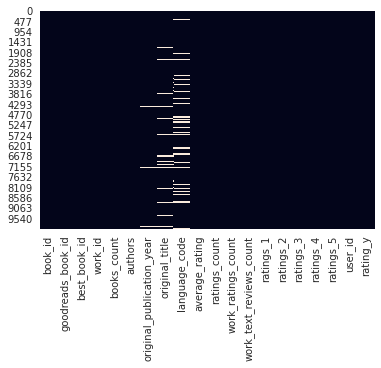

In [0]:
sns.heatmap(df_book.isnull(), cbar=False)

In [0]:
df_book = df_book.dropna()

In [21]:
df_book.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8405 entries, 0 to 9998
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    8405 non-null   int64  
 1   goodreads_book_id          8405 non-null   int64  
 2   best_book_id               8405 non-null   int64  
 3   work_id                    8405 non-null   int64  
 4   books_count                8405 non-null   int64  
 5   authors                    8405 non-null   object 
 6   original_publication_year  8405 non-null   float64
 7   original_title             8405 non-null   object 
 8   language_code              8405 non-null   object 
 9   average_rating             8405 non-null   float64
 10  ratings_count              8405 non-null   int64  
 11  work_ratings_count         8405 non-null   int64  
 12  work_text_reviews_count    8405 non-null   int64  
 13  ratings_1                  8405 non-null   int64

In [0]:
df_book['language_code'].unique()

array(['eng', 'en-US', 'en-CA', 'spa', 'en-GB', 'fre', 'nl', 'ara', 'por',
       'ger', 'nor', 'jpn', 'en', 'vie', 'ind', 'pol', 'tur', 'dan',
       'fil', 'ita', 'per', 'swe', 'rum', 'rus'], dtype=object)

In [0]:
df_book.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8405 entries, 0 to 9998
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    8405 non-null   int64  
 1   goodreads_book_id          8405 non-null   int64  
 2   best_book_id               8405 non-null   int64  
 3   work_id                    8405 non-null   int64  
 4   books_count                8405 non-null   int64  
 5   authors                    8405 non-null   object 
 6   original_publication_year  8405 non-null   float64
 7   original_title             8405 non-null   object 
 8   language_code              8405 non-null   object 
 9   average_rating             8405 non-null   float64
 10  ratings_count              8405 non-null   int64  
 11  work_ratings_count         8405 non-null   int64  
 12  work_text_reviews_count    8405 non-null   int64  
 13  ratings_1                  8405 non-null   int64

Maybe we can consider changing this language_coding into integer, by label enconding


# **We start with the EDA**

In [0]:
df_book.describe()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,user_id,rating_y
count,8405.000000,8.405000e+03,8.405000e+03,8.405000e+03,8405.000000,8405.000000,8405.000000,8.405000e+03,8.405000e+03,8405.000000,8405.000000,8405.000000,8405.000000,8.405000e+03,8.405000e+03,8405.000000,8405.000000
mean,4792.274955,5.175117e+06,5.385698e+06,8.441096e+06,80.189530,1981.731469,3.998337,5.930397e+04,6.555096e+04,3205.675193,1487.058061,3423.093992,12562.882094,2.195356e+04,2.612437e+04,6502.469958,3.900794
std,2887.497909,7.487013e+06,7.753754e+06,1.152411e+07,175.713406,157.358507,0.251581,1.699479e+05,1.811247e+05,6528.800429,7197.096155,10483.407254,30689.758379,5.541098e+04,8.635606e+04,9985.575776,0.281313
min,1.000000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,-1750.000000,2.470000,2.716000e+03,5.510000e+03,11.000000,11.000000,30.000000,323.000000,8.720000e+02,7.540000e+02,1.000000,2.077966
25%,2263.000000,4.390800e+04,4.516900e+04,1.028908e+06,25.000000,1990.000000,3.850000,1.415700e+04,1.618100e+04,772.000000,203.000000,692.000000,3265.000000,5.707000e+03,5.545000e+03,340.000000,3.730435
50%,4692.000000,3.811020e+05,4.009240e+05,2.728068e+06,42.000000,2004.000000,4.010000,2.262000e+04,2.535100e+04,1531.000000,419.000000,1243.000000,5265.000000,9.005000e+03,9.321000e+03,1823.000000,3.919060
75%,7270.000000,8.709527e+06,9.408584e+06,1.414762e+07,71.000000,2011.000000,4.170000,4.508900e+04,5.048900e+04,3097.000000,978.000000,2628.000000,10181.000000,1.764500e+04,1.901900e+04,8464.000000,4.093079
max,9999.000000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06,53331.000000,4.829876


In [0]:
df_top10 = df_book.sort_values(by='ratings_count', ascending=False)[:25]

df_top10.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,user_id,rating_y
0,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,2886,4.279707
1,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,4,4.351350
2,3,41865,41865,3212258,226,Stephenie Meyer,2005.0,Twilight,en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,451,3.214341
3,4,2657,2657,3275794,487,Harper Lee,1960.0,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,15,4.329369
4,5,4671,4671,245494,1356,F. Scott Fitzgerald,1925.0,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,4,3.772224


TOP 10 Books based on the rating count

Text(0.5, 1.0, 'The top 25 popular books')

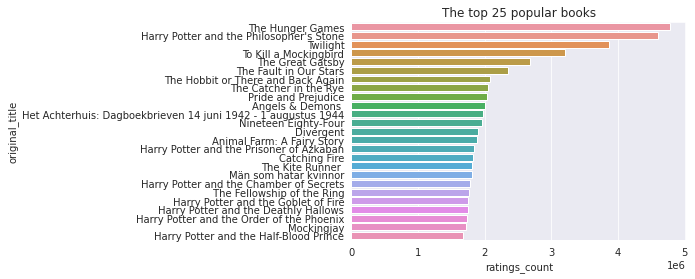

In [0]:
sns.barplot(x=df_top10['ratings_count'], y=df_top10['original_title'])
plt.title('The top 25 popular books')


Top 10 books based on the frequecy they occur

Text(0.5, 1.0, '25 most Occurring Books')

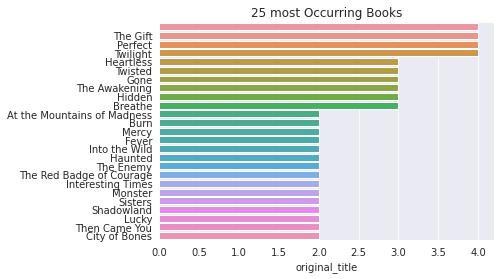

In [0]:
titles = df_book['original_title'].value_counts()[:25]
sns.barplot(x = titles, y = titles.index)
plt.title("25 most Occurring Books")

In [0]:
corr_count_columns = ['ratings_count', 'work_ratings_count', 'work_text_reviews_count']
corr_count_mat = df_book[corr_count_columns].corr()
corr_count_mat

,ratings_count,work_ratings_count,work_text_reviews_count
ratings_count,1.000000,0.995082,0.782092
work_ratings_count,0.995082,1.000000,0.809288
work_text_reviews_count,0.782092,0.809288,1.000000


From the table, we can see the correlation:
-  work_rating_counts and rating_count--> closely correlated almost 1
- rating_counts and work_text_review_count --> highly correlated 
- work_rating_count and work_text_reviews_count --> highly correlated


Now we will plot the correlation matrix for a better visualization

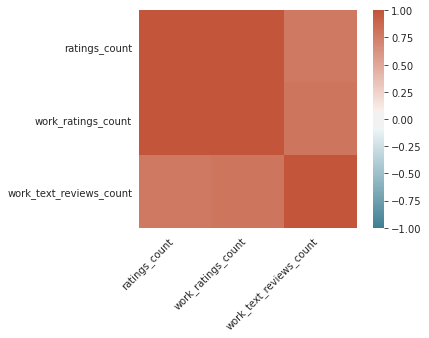

In [0]:

ax = sns.heatmap(
    corr_count_mat, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [0]:
fig = px.scatter(df_book,y='ratings_count', x='work_text_reviews_count')
fig.show()

Since rating_counts and work_rating_count was the highest correlated, we can verify that it sorts of follow a linear regression, the more work_text_review_count means more rating_count

In [0]:
corr_avg_columns = ['average_rating', 'rating_y']
corr_avg_mat = df_book[corr_avg_columns].corr()
corr_avg_mat

,average_rating,rating_y
average_rating,1.000000,0.945067
rating_y,0.945067,1.000000


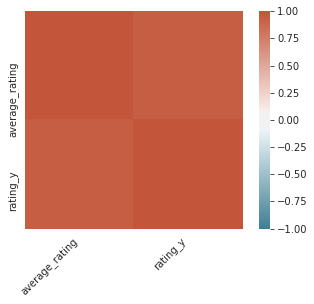

In [0]:
ax = sns.heatmap(
    corr_avg_mat, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [0]:
corr_ratings_columns = ['average_rating', 'ratings_count', 'ratings_1', 'ratings_2','ratings_3','ratings_4','ratings_5']
corr_ratings_mat = df_book[corr_ratings_columns].corr()
corr_ratings_mat

,average_rating,ratings_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
average_rating,1.000000,0.051378,-0.078888,-0.114610,-0.060472,0.044080,0.122266
ratings_count,0.051378,1.000000,0.720841,0.843948,0.934790,0.978838,0.964282
ratings_1,-0.078888,0.720841,1.000000,0.926362,0.794805,0.670272,0.594203
ratings_2,-0.114610,0.843948,0.926362,1.000000,0.949066,0.835953,0.703400
ratings_3,-0.060472,0.934790,0.794805,0.949066,1.000000,0.952555,0.825345
ratings_4,0.044080,0.978838,0.670272,0.835953,0.952555,1.000000,0.934237
ratings_5,0.122266,0.964282,0.594203,0.703400,0.825345,0.934237,1.000000


From the table, we can see the correlation:
-  rating_counts with all rhe ratings (raitngs_4/5/3/2/1)
- ratings_1 and ratings_2 high and then 3/4/5
- ratings_2 and rating_3/1 and then 4/5
- ratings_3 and ratings_4/2/5/1 high
- ratings_4 and ratings_3/5/2/1
- ratings_5 and ratings_4/3 high than 2/1


Now we will plot the correlation matrix for a better visualization

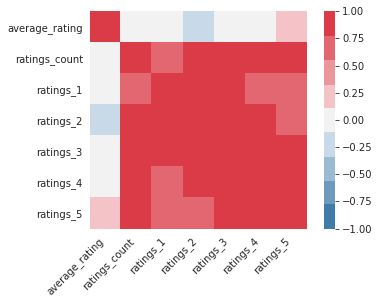

In [0]:
ax = sns.heatmap(
    corr_ratings_mat, 
    vmin=-1, vmax=1, center=0,
    cmap= sns.diverging_palette(240, 10, n=9),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:975: MatplotlibDeprecationWarning:

Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



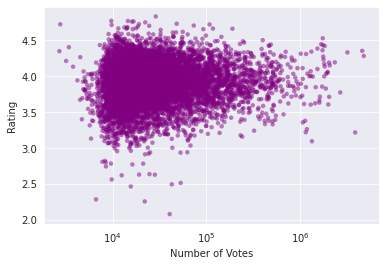

In [0]:
sns.set_style('darkgrid')

df_book.plot(kind='scatter', x='ratings_count', y='rating_y', logx=True, alpha=0.5, color='purple', edgecolor='')
plt.ylabel('Rating')
plt.xlabel('Number of Votes')
plt.show()

Generally more votes means more range of values for the rating, as well as few votes lead to worse rating, as people who never vote, will only vote if they hated the book. Normally, well-known book have lots of votes and high value in rates. 

We will show the top 10 authors based on their books

In [0]:
authors_title = df_book.groupby('authors')['original_title'].count().reset_index().sort_values('original_title', ascending=False)

Now lets see the top 10 auhtors, by number of book with an average rating bigger than 4.5. 

In [0]:
author_top = df_book[df_book['average_rating']>=4.5]
author_top

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,user_id,rating_y
17,18,5,5,2402163,376,"J.K. Rowling, Mary GrandPré, Rufus Beck",1999.0,Harry Potter and the Prisoner of Azkaban,eng,4.53,1832823,1969375,36099,6716,20413,166129,509447,1266670,4,4.418732
23,24,6,6,3046572,332,"J.K. Rowling, Mary GrandPré",2000.0,Harry Potter and the Goblet of Fire,eng,4.53,1753043,1868642,31084,6676,20210,151785,494926,1195045,4,4.430780
24,25,136251,136251,2963218,263,"J.K. Rowling, Mary GrandPré",2007.0,Harry Potter and the Deathly Hallows,eng,4.61,1746574,1847395,51942,9363,22245,113646,383914,1318227,187,4.525941
26,27,1,1,41335427,275,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,4,4.443339
134,135,62291,62291,1164465,175,George R.R. Martin,2000.0,A Storm of Swords,eng,4.54,469022,527644,19497,1456,4820,36418,149268,335682,31,4.420555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9711,9712,17333174,17333174,24064358,14,Ilona Andrews,2016.0,Magic Binds,eng,4.57,10983,14525,1656,28,66,894,4089,9448,23496,4.535714
9780,9781,6081686,6081686,6258393,15,Hiro Fujiwara,2007.0,会長はメイド様! 2,eng,4.53,9843,10514,123,60,186,992,2175,7101,16125,4.441558
9841,9842,24019187,24019187,43618137,12,Brandon Stanton,2015.0,Humans of New York: Stories,eng,4.50,12527,12852,1210,191,211,901,3231,8318,23067,4.588235
9922,9923,228200,228200,9813455,26,Stephen King,1996.0,"The Green Mile, Part 5: Night Journey",eng,4.51,11442,11918,111,26,122,1015,3282,7473,361,4.538835


Text(0, 0.5, 'Authors')

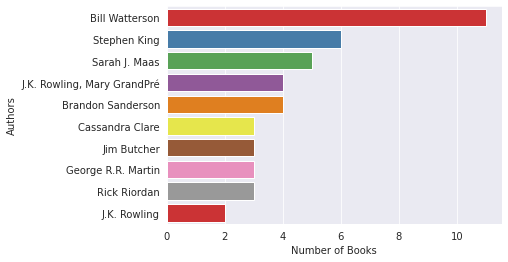

In [0]:
author_top = author_top.groupby('authors')['original_title'].count().reset_index().sort_values('original_title', ascending = False).head(10).set_index('authors')

ax = sns.barplot(author_top['original_title'], author_top.index, palette='Set1')
ax.set_xlabel("Number of Books")
ax.set_ylabel("Authors")



Now we have to dataframes:
- df_books --> this one will be used for the simple recommender system based on the rating, the voter_counts and the author content-based
-df_book_test --> tag_name content based and for the combination of both 

## **SIMPLE RECOMMENDER SYSTEM**

 Weighted Rating (WR) =  (𝑣𝑣+𝑚.𝑅)+(𝑚𝑣+𝑚.𝐶) 

 where,
v is the number of votes for the movie;
m is the minimum votes required to be listed in the chart;
R is the average rating of the movie; And
C is the mean vote across the whole report


We will be using this formula, so that we dont suggest only in the rating, but we also take into account the number of voters. 

In [0]:
df_book.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,user_id,rating_y
0,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,2886,4.279707
1,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,4,4.351350
2,3,41865,41865,3212258,226,Stephenie Meyer,2005.0,Twilight,en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,451,3.214341
3,4,2657,2657,3275794,487,Harper Lee,1960.0,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,15,4.329369
4,5,4671,4671,245494,1356,F. Scott Fitzgerald,1925.0,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,4,3.772224


In [0]:
# Calculate C, we will be using the rating_y we calculated from the ratings.csv instead of the one provided
C = df_book['rating_y'].mean()
print(C)

3.9007941206790053


The average rating of a book  is around 3.9, on a scale of 5.

Next, let's calculate the number of votes, m, received by a book in the 90th percentile. 

In [0]:
# Calculate the minimum number of votes required to be in the chart, m
m = df_book['ratings_count'].quantile(0.90)
print(m)

104991.20000000003


In [0]:
# Filter out all qualified movies into a new DataFrame
quality_books = df_book.copy().loc[df_book['ratings_count'] >= m]
quality_books.shape

(841, 20)

You see that there are 841 movies which qualify to be in this list. Now, we will calculate the metric for each qualified movie, by defining a funciton called weighted_rating() and define a new feature score, of which you'll calculate the value by applying this function to your DataFrame of qualified movies. 

In [0]:
# Function that computes the weighted rating of each book
def weighted_rating(x, m=m, C=C):
    v = x['ratings_count']
    R = x['rating_y']
    # Calculation based on the formula we saw in class
    return (v/(v+m) * R) + (m/(m+v) * C)

In [0]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
quality_books['score'] = quality_books.apply(weighted_rating, axis=1)

Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 15 movies.

In [0]:
#Sort books based on score calculated above
quality_books = quality_books.sort_values('score', ascending=False)

#Print the top 15 movies
quality_books[['original_title', 'ratings_count', 'rating_y', 'score']].head(15)

,original_title,ratings_count,rating_y,score
24,Harry Potter and the Deathly Hallows,1746574,4.525941,4.490493
26,Harry Potter and the Half-Blood Prince,1678823,4.443339,4.411406
23,Harry Potter and the Goblet of Fire,1753043,4.430780,4.400832
17,Harry Potter and the Prisoner of Azkaban,1832823,4.418732,4.390670
421,Complete Harry Potter Boxed Set,190050,4.659530,4.389532
191,The Name of the Wind,400101,4.499747,4.375245
30,The Help,1531753,4.382887,4.351962
143,"Unbroken: A World War II Story of Survival, Re...",487775,4.439371,4.343978
1,Harry Potter and the Philosopher's Stone,4602479,4.351350,4.341301
20,Harry Potter and the Order of the Phoenix,1735368,4.358697,4.332574


You see that results, is similar to one of the graph with the top 25 books: 
- all harry potter books 
- to kill a mockingbird 

7/25 books show in the top25 as the we show in the EDA step. 



## **CONTENT BASED RECOMMENDER SYSTEM**

We will be doing 3 different content based:
- Author content based
- Tag_name content based 
- Combination of both 

In [0]:
df_book.head(25)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,user_id,rating_y
0,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,2886,4.279707
1,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,4,4.351350
2,3,41865,41865,3212258,226,Stephenie Meyer,2005.0,Twilight,en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,451,3.214341
3,4,2657,2657,3275794,487,Harper Lee,1960.0,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,15,4.329369
4,5,4671,4671,245494,1356,F. Scott Fitzgerald,1925.0,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,4,3.772224
5,6,11870085,11870085,16827462,226,John Green,2012.0,The Fault in Our Stars,eng,4.26,2346404,2478609,140739,47994,92723,327550,698471,1311871,11365,4.190696
6,7,5907,5907,1540236,969,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,en-US,4.25,2071616,2196809,37653,46023,76784,288649,665635,1119718,32,4.148477
7,8,5107,5107,3036731,360,J.D. Salinger,1951.0,The Catcher in the Rye,eng,3.79,2044241,2120637,44920,109383,185520,455042,661516,709176,4,3.710406
8,9,960,960,3338963,311,Dan Brown,2000.0,Angels & Demons,en-CA,3.85,2001311,2078754,25112,77841,145740,458429,716569,680175,9,3.604416
9,10,1885,1885,3060926,3455,Jane Austen,1813.0,Pride and Prejudice,eng,4.24,2035490,2191465,49152,54700,86485,284852,609755,1155673,9,4.186984


**Author Based Recommender**

In [0]:


tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_book['authors'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [0]:
# an array with all the titles 
titles = df_book['original_title']
indices = pd.Series(df_book.index, index=df_book['original_title'])

def authors_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

We will use the cosine similarity, and if we have time we can try with others like pearson.

In [0]:
authors_recommendations('Harry Potter and the Deathly Hallows').head(20)

20              Harry Potter and the Order of the Phoenix
22                Harry Potter and the Chamber of Secrets
23                    Harry Potter and the Goblet of Fire
24                   Harry Potter and the Deathly Hallows
26                 Harry Potter and the Half-Blood Prince
2100                     Harry Potter Boxed Set Books 1-4
17               Harry Potter and the Prisoner of Azkaban
341                                    The Casual Vacancy
398                          The Tales of Beedle the Bard
421                       Complete Harry Potter Boxed Set
3752         Harry Potter Collection (Harry Potter, #1-6)
4640    Fantastic Beasts and Where to Find Them: The O...
7522         Hogwarts: An Incomplete and Unreliable Guide
6427    Short Stories from Hogwarts of Heroism, Hardsh...
7442    Short Stories from Hogwarts of Power, Politics...
252                                  The Cuckoo's Calling
694                                          The Silkworm
1064          

The result print the books that have been written by the same author as Harry Potter, hence all Harry Potter saga are top 9. 

In [22]:
df_book_test.head(25)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,tag_id,tag_name,count
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,698,2012-reads,358
100,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,1128,5-stars,1049
200,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,1128,5-stars,283
300,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,236,1001,353
400,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,236,1001,363
500,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,The Fault in Our Stars,eng,4.26,2346404,2478609,140739,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m...,https://images.gr-assets.com/books/1360206420s...,722,2013-reads,390
600,7,5907,5907,1540236,969,618260307,9.780618e+12,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,The Hobbit,en-US,4.25,2071616,2196809,37653,46023,76784,288649,665635,1119718,https://images.gr-assets.com/books/1372847500m...,https://images.gr-assets.com/books/1372847500s...,236,1001,282
700,8,5107,5107,3036731,360,316769177,9.780317e+12,J.D. Salinger,1951.0,The Catcher in the Rye,The Catcher in the Rye,eng,3.79,2044241,2120637,44920,109383,185520,455042,661516,709176,https://images.gr-assets.com/books/1398034300m...,https://images.gr-assets.com/books/1398034300s...,236,1001,345
800,9,960,960,3338963,311,1416524797,9.781417e+12,Dan Brown,2000.0,Angels & Demons,"Angels & Demons (Robert Langdon, #1)",en-CA,3.85,2001311,2078754,25112,77841,145740,458429,716569,680175,https://images.gr-assets.com/books/1303390735m...,https://images.gr-assets.com/books/1303390735s...,615,2005,93
900,10,1885,1885,3060926,3455,679783261,9.780680e+12,Jane Austen,1813.0,Pride and Prejudice,Pride and Prejudice,eng,4.24,2035490,2191465,49152,54700,86485,284852,609755,1155673,https://images.gr-assets.com/books/1320399351m...,https://images.gr-assets.com/books/1320399351s...,236,1001,363


In [23]:
type(df_book_test['tag_name'][0])

str

In [0]:
tf1 = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix1 = tf1.fit_transform(df_book_test['tag_name'].head(10000))
cosine_sim1 = linear_kernel(tfidf_matrix1, tfidf_matrix1)

In [0]:
#an array with all the titles
titles1 = df_book_test['title']
indices1 = pd.Series(df_book_test.index, index=df_book_test['title'])


def tags_recommendations(title):
    idx = indices1[title]
    sim_scores = list(enumerate(cosine_sim1[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles1.iloc[book_indices]

In [0]:
tags_recommendations('The Hunger Games (The Hunger Games, #1)').head(20)

1100                             Divergent (Divergent, #1)
1600                  Catching Fire (The Hunger Games, #2)
1900                     Mockingjay (The Hunger Games, #3)
6800                             Insurgent (Divergent, #2)
16500                                Matched (Matched, #1)
18400                                     The Night Circus
20200                   Beautiful Disaster (Beautiful, #1)
21700                         Bared to You (Crossfire, #1)
28900    Is Everyone Hanging Out Without Me? (And Other...
33300                     Reflected in You (Crossfire, #2)
43400                                        Before I Fall
44400                                 Before I Go to Sleep
58800                     Easy (Contours of the Heart, #1)
64300                                Slammed (Slammed, #1)
76000                                        Twenties Girl
79500              On Dublin Street (On Dublin Street, #1)
83600                            Every Day (Every Day, #

For this one, I have used the title and not the original_title, because I seem to have some problems with the indices when using the original_title, and it did not recommend properly. However, the indices are also incrementing by 100, instead by one, like it did in authors. I have had that problem throughout the entire lab, but I thought I fixed it, since in the author recommender the indices increment by 1. I don't seem to find the solution, but I don't quite understand why it works with indices bigger than 10000, as in the author recommender, I always had the output error that it the indices exceed 10000. 


Besides this problem, we can see that according to the tag_name which it was 2012_reads, it showed the most related book considering the tag_name. The first one is Divergent, that happens to have the tag_name.

The tag_name identifies the 'genre' more or less, therefore all the harry potter books and related are shown. 

**Author and tag_name content based Recommender**

---



---



In [0]:
book_tag_name = df_book_test.groupby('book_id')['tag_name'].apply(' '.join).reset_index()

We combine both results in one column named combo, so that we can access to both information. 

In [0]:
df_book_test['combo'] = (pd.Series(df_book_test[['authors', 'tag_name']].fillna('').values.tolist()).str.join(' '))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
df_book_test.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,tag_id,tag_name,count,combo
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,698,2012-reads,358,Suzanne Collins 2012-reads
100,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,1128,5-stars,1049,NaN
200,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,1128,5-stars,283,NaN
300,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,236,1001,353,NaN
400,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,236,1001,363,NaN


In [0]:
df_book_test = df_book_test.dropna()

In [0]:
tf_combo = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix_combo = tf_combo.fit_transform(df_book_test['combo'])
cosine_sim_combo = linear_kernel(tfidf_matrix_combo, tfidf_matrix_combo)

In [0]:
titles = df_book_test['title']
indices = pd.Series(df_book_test.index, index=df_book_test['title'])


def combo_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_combo[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]



In [0]:
tags_recommendations('The Hunger Games (The Hunger Games, #1)').head(20)

1100                             Divergent (Divergent, #1)
1600                  Catching Fire (The Hunger Games, #2)
1900                     Mockingjay (The Hunger Games, #3)
6800                             Insurgent (Divergent, #2)
16500                                Matched (Matched, #1)
18400                                     The Night Circus
20200                   Beautiful Disaster (Beautiful, #1)
21700                         Bared to You (Crossfire, #1)
28900    Is Everyone Hanging Out Without Me? (And Other...
33300                     Reflected in You (Crossfire, #2)
43400                                        Before I Fall
44400                                 Before I Go to Sleep
58800                     Easy (Contours of the Heart, #1)
64300                                Slammed (Slammed, #1)
76000                                        Twenties Girl
79500              On Dublin Street (On Dublin Street, #1)
83600                            Every Day (Every Day, #

## **Conclusion**

I found this lab really interesting, and compared to the last I was feeling more confident, even though I had no time to do the collaborative filtering, I will try to do it for my end of project. 

I had real trouble with the indices, when trying to set all the title in 1D, and still don't understand why sometimes it works and other time the indices exceeds. 

